# Sentinel-2 multispectral imagery
### Does the modeled surface water (ponded water) match what is seen from multispectral imagery?

!!! need to get the files from download_S2.ipynb to actually export the right format (should be a mask with one band, not 4)

In [1]:
import mikeio
import matplotlib.pyplot as plt
import geopandas as gpd
import tools

<Axes: >

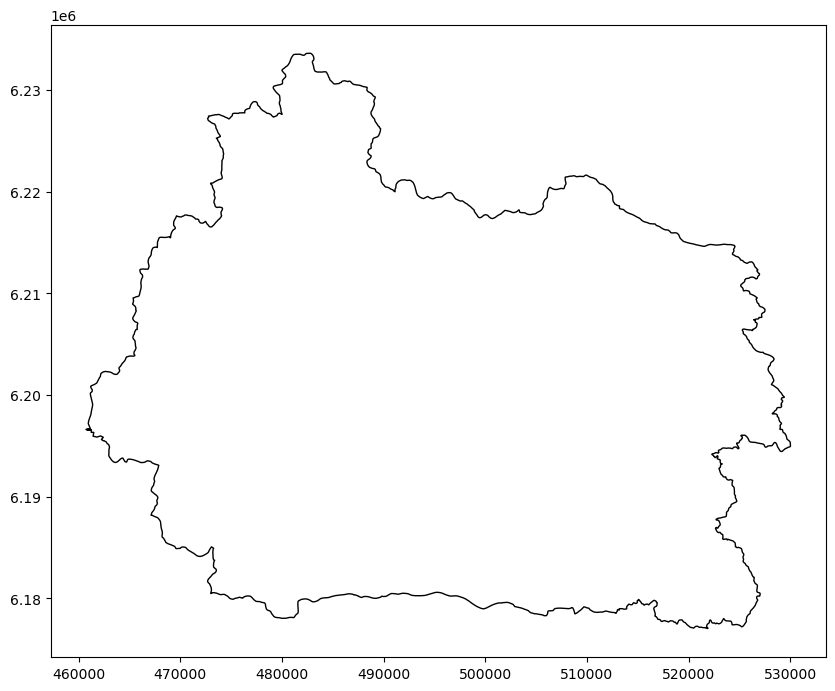

In [2]:
# Domain data
fig, ax = plt.subplots(figsize=(10, 10))
domain_shp = gpd.read_file( r"..\MapsDK\DKDomains2013\ID15_oplande_Skjern.shp")
domain_shp.plot(facecolor='none', edgecolor='black',ax=ax)


In [24]:
import rasterio
from rasterio.transform import xy
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

def plot_mask_with_boundary(tif_path, shapefile_path):
    # Read shapefile
    gdf = gpd.read_file(shapefile_path)

    # Read raster
    with rasterio.open(tif_path) as src:
        mask = src.read(1)  # first band
        transform = src.transform
        raster_crs = src.crs

    # Mask NaNs or zeros (optional, for water mask display)
    mask = np.where(mask == 0, np.nan, mask)

    # Reproject shapefile to raster CRS
    gdf_proj = gdf.to_crs(raster_crs)

    # Create coordinate mesh for plotting
    rows, cols = np.meshgrid(np.arange(mask.shape[0]), np.arange(mask.shape[1]), indexing='ij')
    xs, ys = xy(transform, rows, cols)

    # Convert xs, ys from 2D arrays to extent for imshow
    extent = [np.min(xs), np.max(xs), np.min(ys), np.max(ys)]

    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(mask, cmap="Blues", extent=extent, origin='upper')
    gdf_proj.boundary.plot(ax=ax, edgecolor="red", linewidth=1.5)
    plt.colorbar(im, ax=ax, label="Water Mask Value")
    plt.title("Water Mask with Boundary")
    plt.xlabel("Easting")
    plt.ylabel("Northing")
    plt.show()
    return mask, extent, gdf_proj



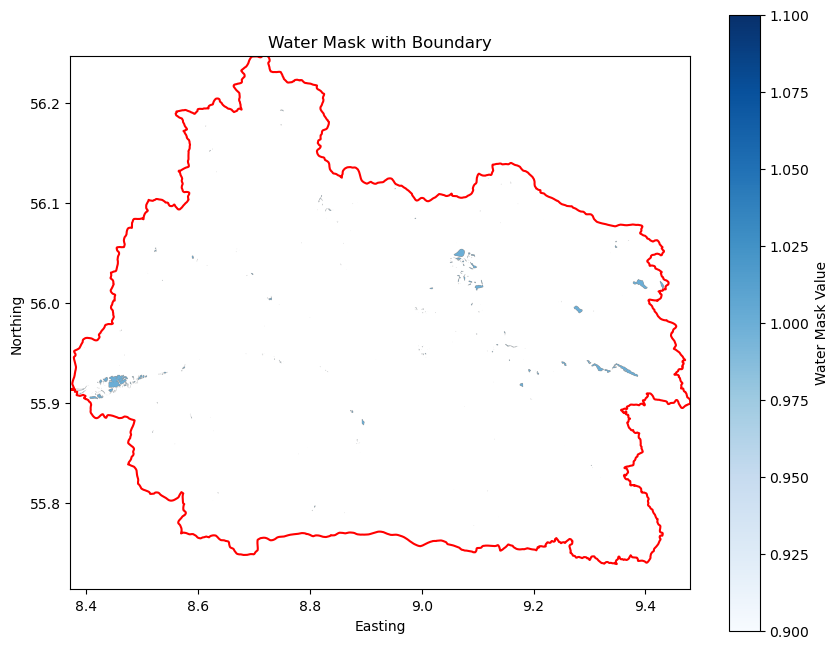

In [28]:
# Example usage
path = r"..\MS\S2_WaterMask_skjern_0419.tif"

s2_mask_ll, extent_ll, boundary_ll = plot_mask_with_boundary(path, r"..\MapsDK\DKDomains2013\ID15_oplande_Skjern.shp")

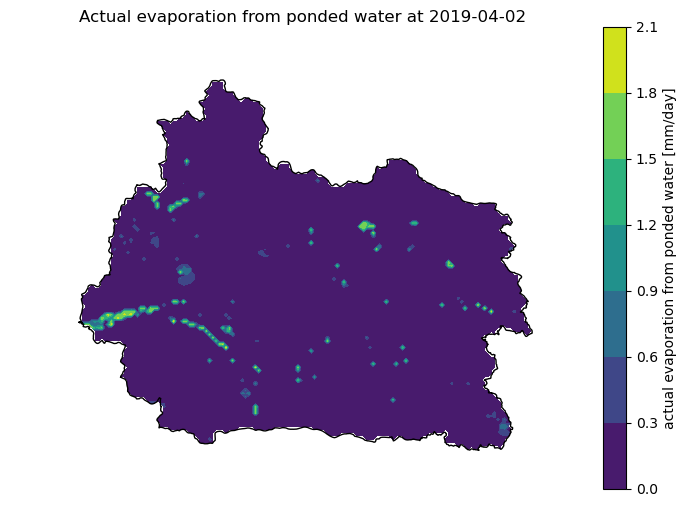

In [32]:
# Load in MIKESHE results for ponded water evaporation (i.e. ponded water extent)

tools.plot_dfs2_output(r"..\Skjern_Models\Setup\HIP_500m_Skjern_DHI.she - Result Files\HIP_500m_Skjern_DHI_ET_UzCells.dfs2", varname='actual evaporation from ponded water', timeID=763, ax=None, shapefile=domain_shp)

OWevt_dfs2 = mikeio.read(r"..\Skjern_Models\Setup\HIP_500m_Skjern_DHI.she - Result Files\HIP_500m_Skjern_DHI_ET_UzCells.dfs2")
varname='actual evaporation from ponded water'
timeID = 763  # selected time step
OWevt_dfs2 = OWevt_dfs2[varname][timeID]
OWevt_xr = OWevt_dfs2.to_xarray()

df = OWevt_xr.to_dataframe().reset_index()
gdf = gpd.GeoDataFrame(
    df[varname], geometry=gpd.points_from_xy(df.x,df.y))

# rename varname to 'OWTD'
gdf.rename(columns={varname: 'evt'}, inplace=True)

# export geodataframe to shapefile
gdf.crs = "EPSG:32632"  # EPSG for UTM 32N (WGS 84)
#gdf.to_file(r"..\Skjern_Models\Setup\HIP_500m_Skjern_DHI.she - Result Files\evt_ponded_water.shp")


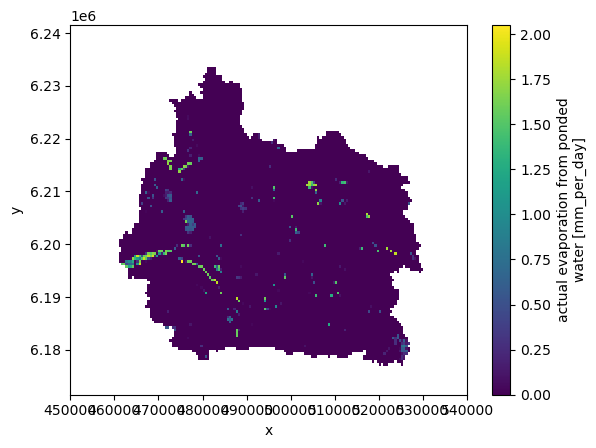

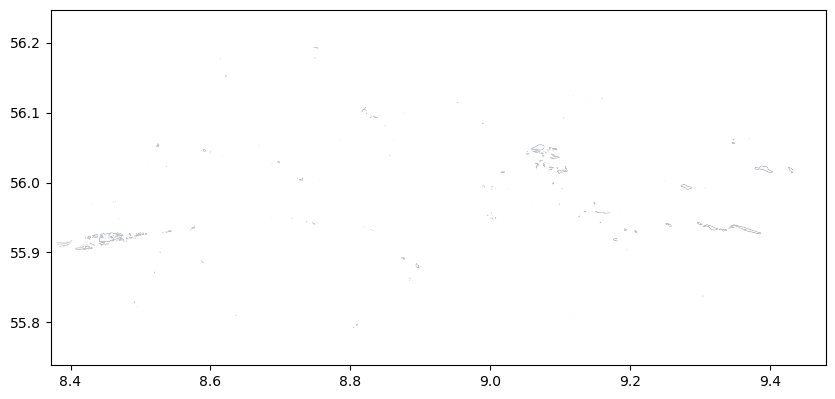

In [33]:
OWevt_xr.plot()
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(s2_mask_ll, cmap="Blues", extent=extent_ll, origin='upper')


In [ ]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

# need to reproject S2 mask raster to the same CRS as OWevt_xr
dst_crs = 'EPSG:32632' # UTM 32N for WGS 84

S2_file_path = r"..\MS\S2_WaterMask_skjern_0419.tif" # currently in LL¨
S2_file_out_path = r"..\MS\S2_WaterMask_skjern_0419_32N.tif" # currently in LL

# From https://rasterio.readthedocs.io/en/stable/topics/reproject.html
with rasterio.open(S2_file_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(S2_file_out_path, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

# plot new reprojected mask
plot_mask_with_boundary(S2_file_out_path, r"..\MapsDK\DKDomains2013\ID15_oplande_Skjern.shp")

<class 'numpy.ndarray'>
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
<class 'numpy.ndarray'>
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


<class 'numpy.ndarray'>
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
(5661, 12339)
<class 'numpy.ndarray'>
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
(140, 180)
<class 'numpy.ndarray'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(8626, 10574)
(8626, 10574)
<class 'numpy.ndarray'>
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


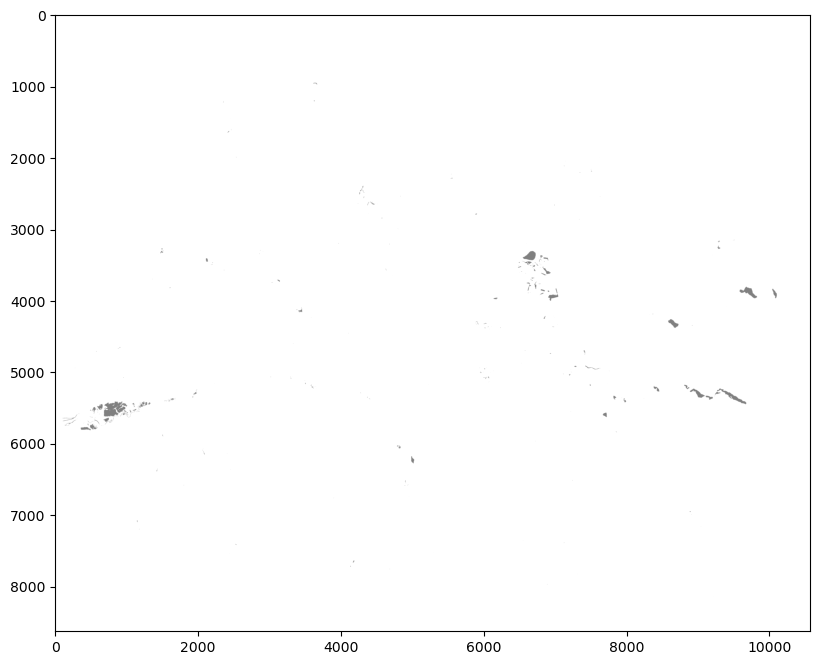

In [ ]:
# read in file and plot
print(type(s2_mask_ll))
print(s2_mask_ll)
print(np.shape(s2_mask_ll))
print(type(OWevt_xr.values))
print(OWevt_xr.values)
print(np.shape(OWevt_xr.values))

with rasterio.open(S2_file_out_path) as src:
        mask_utm = src.read(1)  # first band
        transform = src.transform
        raster_crs = src.crs

print(type(mask_utm))
print(mask_utm)
print(np.shape(mask_utm))

# set zeros to nan in mask_utm and recalculate shape
mask_utm = np.where(mask_utm == 0, np.nan, mask_utm)
# Mask NaNs or zeros (optional, for water mask display)
print(np.shape(mask_utm))
print(type(mask_utm))
print(mask_utm)

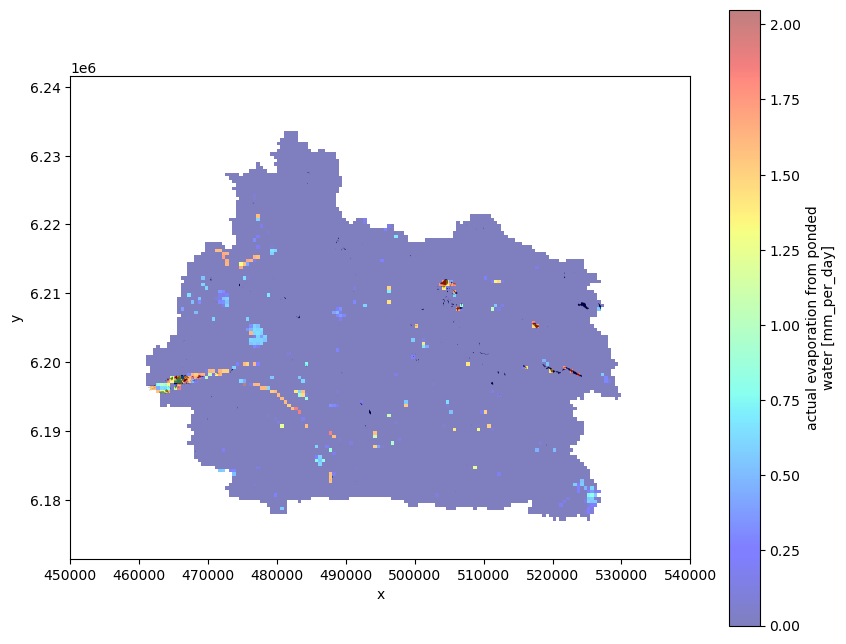

In [60]:
# plot mask_utm and OWevt_xr.values on same plot

rows, cols = np.meshgrid(np.arange(mask_utm.shape[0]), np.arange(mask_utm.shape[1]), indexing='ij')
xs, ys = xy(transform, rows, cols)

# Convert xs, ys from 2D arrays to extent for imshow
extent_utm = [np.min(xs), np.max(xs), np.min(ys), np.max(ys)]

fig, ax = plt.subplots(figsize=(10, 8))
OWevt_xr.plot(ax=ax, cmap='jet', alpha=0.5)
#ax.imshow(OWevt_xr, cmap='jet', alpha=0.5)
ax.imshow(mask_utm,extent=extent_utm, cmap='magma', alpha=1.0)


In [ ]:
# resample S2 mask to same resolution as OWevt_xr
mask_utm_resampled = mask_utm.copy()


In [ ]:
# Compare location of ponded water evaporation with water mask -  compute spatial correlation and distance error
